In [1]:
import torch
from PICOHelper import get_pico_datasets
from NewsroomHelper import get_newsroom_datasets
from SummarizationModelStructures import GeneratorModel, loss_function, error_function
from utils import DataLoader, get_index_words
from pytorch_helper import ModelManipulator, plot_learning_curves

# Parameters

In [2]:
# training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 1
LEARNING_RATE = 1e-2
# INITIAL_ACCUMULATOR_VALUE = 0.1
GAMMA = 1
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


# Get Data

In [3]:
# pico_dataset_train, pico_dataset_dev, pico_dataset_test = get_pico_datasets()
newsroom_dataset_train, newsroom_dataset_dev, newsroom_dataset_test = get_newsroom_datasets()
word_vectors = newsroom_dataset_train.word_vectors
start_index = newsroom_dataset_train.word_indices['<start>']
end_index = newsroom_dataset_train.word_indices['<end>']

11029 3676 3678
retrieving word2vec model from file


# Create Model

In [4]:
generator_model = GeneratorModel(word_vectors, start_index, end_index, num_hidden1=None, num_hidden2=None, with_coverage=False, gamma=GAMMA)

# Train and Save Model

In [5]:
dataloader = DataLoader(newsroom_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(generator_model.parameters(),
                             lr=LEARNING_RATE)
# optimizer = torch.optim.Adagrad((generator_model.cuda() if USE_CUDA else generator_model).parameters(),
#                                 lr=LEARNING_RATE, initial_accumulator_value=INITIAL_ACCUMULATOR_VALUE)
model_manip = ModelManipulator(generator_model, optimizer, loss_function, error_function, use_cuda=USE_CUDA)
train_stats, val_stats = model_manip.train(dataloader, NUM_EPOCHS, dataset_val=newsroom_dataset_dev, stats_every=10, verbose_every=10)

epoch: 0, batch: 0, train_loss: 216.256210, train_error: None
epoch: 0, batch: 10, train_loss: 158.585083, train_error: None
epoch: 0, batch: 20, train_loss: 182.051727, train_error: None
epoch: 0, batch: 30, train_loss: 207.657684, train_error: None
epoch: 0, batch: 40, train_loss: 143.115738, train_error: None
epoch: 0, batch: 50, train_loss: 156.565720, train_error: None
epoch: 0, batch: 60, train_loss: 86.784584, train_error: None
epoch: 0, batch: 70, train_loss: 186.224091, train_error: None
epoch: 0, batch: 80, train_loss: 113.260948, train_error: None
epoch: 0, batch: 90, train_loss: 92.053711, train_error: None
epoch: 0, batch: 100, train_loss: 101.834839, train_error: None
epoch: 0, batch: 110, train_loss: 96.822723, train_error: None
epoch: 0, batch: 120, train_loss: 82.193771, train_error: None
epoch: 0, batch: 130, train_loss: 103.215202, train_error: None
epoch: 0, batch: 140, train_loss: 99.930756, train_error: None
epoch: 0, batch: 150, train_loss: 103.595276, train_erro

In [6]:
torch.save(generator_model, 'data/generator_test.model')

In [ ]:
generator_model = torch.load('data/generator_test.model')

# Plot

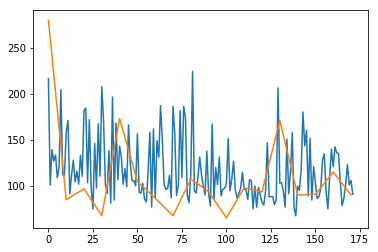

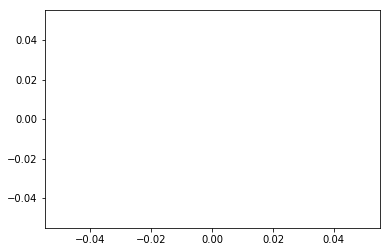

In [7]:
plot_learning_curves(training_values=train_stats, validation_values=val_stats, figure_name='generator_training_test')

In [8]:
batch = newsroom_dataset_dev[0:5]
loss, summary_info = generator_model(batch['text'].cuda(), batch['text_length'].cuda())
# generated_output = generator_model(batch['text'], batch['text_length'])

In [9]:
for i,indices in enumerate(summary_info[0]):
    text, l = batch['text'][i], batch['text_length'][i]
    print("text", get_index_words(text[:l].numpy(), newsroom_dataset_train.words))
    text, l = batch['summary'][i], batch['summary_length'][i]
    print("summary", get_index_words(text[:l].numpy(), newsroom_dataset_train.words))
    print("generated summary", get_index_words(indices[:summary_info[1][i]], newsroom_dataset_train.words))
print(loss)

text ['<start>', 'you', 'can', 'say', 'this', 'for', 'the', 'new', 'miami', 'dolphins', 'uniforms', ':', 'it', '’s', 'not', 'the', 'worst', 'redesign', 'by', 'a', 'florida', '-', 'based', 'nfl', 'team', 'to', 'be', 'revealed', 'on', 'tuesday', '.', 'hours', 'after', 'the', 'jacksonville', 'jaguars', 'unveiled', 'their', 'new', 'oov', '-', 'like', 'uniforms', ',', 'paul', 'lukas', 'of', 'uni', 'watch', 'tweeted', 'a', 'picture', 'of', 'the', 'leaked', 'dolphins', 'kits', 'for', 'the', 'upcoming', 'season', '.', 'confirmed', 'leak', 'of', 'new', 'miami', 'dolphins', 'uniforms', ':', 'oov', '…', '—', 'paul', 'lukas', '(', 'oov', ')', 'april', 'qqq', ',', 'qqq', 'qqq', '.', 'the', 'uniforms', 'do', 'n’t', 'look', 'all', 'that', 'different', 'from', 'the', 'old', 'ones', '.', 'they', '’re', 'sleeker', 'and', 'more', 'modern', ',', 'but', 'without', 'a', 'qqq', 'press', 'release', 'from', 'nike', 'talking', 'about', 'the', 'subtle', 'shift', 'in', 'colors', 'and', 'adjustments', 'to', 'the',